In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display  import Audio
from sklearn import preprocessing
import seaborn as sns
import missingno as msno
import plotly.graph_objects as go

### Feature Selection

In [24]:
# Código Nicolás: he tratado de hacer que se extraigan las caracteríscas en ventanas de 10 ms
def normalize(x, axis = 0):
    return preprocessing.minmax_scale(x, axis = axis)

def extrae_var(cancion):

    # Obtener la muestra de audio (samples) y el tamaño de la ventana(sr)
    samples, sr = librosa.load(cancion)

    features = [cancion]

    # Configuración para ventanas de 10 ms
    frame_length = 512  # 20 ms en muestras (20 y algo para que sea múltiplo de 2)
    hop_length = 64  # Salto de 10 ms (10 y algo para que sea múltiplo de 2)

    # Tempo
    onset_env = librosa.onset.onset_strength(y=samples, sr=sr, hop_length = hop_length, n_fft=frame_length)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    features.append(tempo)

    # Espectrograma
    spectrogram = np.abs(librosa.stft(samples, hop_length=hop_length, n_fft=frame_length))
    features.append(np.median(spectrogram))

    # Mel Spectogram
    mel_spectogram = librosa.feature.melspectrogram(y=samples, sr=sr, n_fft=frame_length, hop_length=hop_length, n_mels=128)
    features.append(np.median(mel_spectogram))

    # Media de la energía en cada ventana de 10 ms
    rms = librosa.feature.rms(y=samples, hop_length = hop_length, frame_length=frame_length)[0]
    features.append(np.median(rms))

    # Centroides espectrales
    spectral_centroids = librosa.feature.spectral_centroid(y=samples, sr=sr, hop_length = hop_length, n_fft=frame_length)[0]
    features.append(np.median(spectral_centroids))

    # Ancho de banda de frecuencia
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=samples, sr=sr, hop_length = hop_length, n_fft=frame_length)[0]
    features.append(np.median(spectral_bandwidth))

    # Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=samples + 0.01, sr=sr, hop_length = hop_length, n_fft=frame_length)[0]
    features.append(np.median(spectral_rolloff))

    # Tonnetz
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(samples), sr=sr)
    features.append(np.median(tonnetz))

    # ZCR
    zero_crossings= librosa.feature.zero_crossing_rate(y=samples, frame_length=frame_length, hop_length=hop_length)[0]
    features.append(np.median(zero_crossings))

    # Cromatica
    cromatica = librosa.feature.chroma_stft(y=samples, sr=sr, hop_length = hop_length, n_fft=frame_length)[0]
    features.append(np.median(cromatica))

    # TEMPOGRAMA
    tempograma = librosa.feature.tempogram(onset_envelope = onset_env, sr = sr, hop_length = hop_length, win_length=frame_length)[0]

    # Auto-correlation
    auto_c = librosa.autocorrelate(onset_env, max_size = tempograma.shape[0])
    auto_c = librosa.util.normalize(auto_c)
    features.append(np.median(auto_c))

    # MFCCS
    mfccs = librosa.feature.mfcc(y = samples, sr = sr, n_mfcc=20)
    
    columnas = ['archivo', 'tempo', 'spectrogram', 'mel_spectrogram', 'rms', 'spectral_centroids', 'spectral_bandwith', 'spectral_rf', 'tonnetz', 'zero_crossings', "cromatica", "auto-correlation"]

    for x in range(1, 21):
        columnas.append(f'mfcc_{x}')

    features.extend([np.median(m) for m in mfccs])

    df = pd.DataFrame(columns=columnas)

    # Fila de datos
    df.loc[len(df)] = features

    return df

In [25]:
df_t=pd.DataFrame()
i=0
for subcarpeta in os.listdir('data'):
    print("Procesando canciones de:", subcarpeta)
    for archivo in os.listdir('data/'+subcarpeta):
        if archivo.endswith('.mp3'):
            cancion='data/'+subcarpeta +'/'+archivo
            df=extrae_var(cancion)
            df['Genero_label']=i #genera una etiqueta numerica para entrenamiento de modelo
            df['Genero']=subcarpeta #genera etiqueta de nombre para las resententaciones
            df_t=pd.concat([df_t,df])
            
    i=i+1
df_t.reset_index(drop=True,inplace=True)

Procesando canciones de: jazz
Procesando canciones de: opera


KeyboardInterrupt: 

In [22]:
df_t

,archivo,tempo,rms,spectral_centroids,spectral_bandwith,spectral_rf,tonnetz,zero_crossings,cromatica,auto-correlation,...,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,Genero_label,Genero
0,data/jazz/Body And Soul (2008 Remastered)_4LnE...,123.046875,0.092547,1092.073,1367.988176,1894.921875,0.024475,0.058594,0.409816,0.451008,...,-5.664621,-2.206847,-5.13887,-0.625633,-1.046974,-0.461257,-2.62639,-1.1192,0,jazz


In [65]:
# Si quereis usar datos escalados


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#dataset escalado y separado en train y test para entrenar modelos.
df2=df_t.drop(['archivo','Genero','Genero_label'], axis=1).copy()
scaler=StandardScaler()
df_scaled=scaler.fit_transform(df2)
df_scaled=pd.DataFrame(df_scaled, columns=df2.columns.to_list())
df_scaled['archivo']=df_t['archivo']
df_scaled['Genero']=df_t['Genero']
df_scaled['Genero_label']=df_t['Genero_label'] 
df_train,df_test=train_test_split(df_scaled,test_size=0.2,random_state=123, stratify=df_scaled['Genero_label'])
X_train=df_train.drop(['archivo','Genero','Genero_label'], axis=1).copy()
y_train=df_train['Genero_label']
X_test=df_test.drop(['archivo','Genero','Genero_label'], axis=1).copy()
y_test=df_test['Genero_label']

#dataset escalado para cluster kmeans o jerarquico
df_cluster=df_scaled.drop(['archivo','Genero','Genero_label'], axis=1).copy() 


In [ ]:
# Si quereis usar datos NO escalados


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#dataset NO escalado y separado en train y test para entrenar modelos.
df_train,df_test=train_test_split(df_t,test_size=0.2,random_state=123, stratify=df_t['Genero_label'])
X_train=df_train.drop(['archivo','Genero','Genero_label'], axis=1).copy()
y_train=df_train['Genero_label']
X_test=df_test.drop(['archivo','Genero','Genero_label'], axis=1).copy()
y_test=df_test['Genero_label']



#dataset NO escalado para cluster kmeans o jerarquico
df_cluster=df_t.drop(['archivo','Genero','Genero_label'], axis=1).copy() 

### PCA

#### Obtención de valores y vectores propios para poder entender que variables són más influyentes en el dataset

In [66]:
corr_matrix = np.corrcoef(df_cluster.T)
eig_vals, eig_vectors = np.linalg.eig(corr_matrix)
# Comprobamos que la longitud de los vecotes propios sea 1 (es decir, //ai// = 1)
for ev in eig_vectors:
    print("La longitud del Vector Propio es: %s"%np.linalg.norm(ev))

La longitud del Vector Propio es: 1.0
La longitud del Vector Propio es: 0.9999999999999998
La longitud del Vector Propio es: 0.9999999999999998
La longitud del Vector Propio es: 0.999999999999998
La longitud del Vector Propio es: 0.9999999999999992
La longitud del Vector Propio es: 1.0000000000000007
La longitud del Vector Propio es: 1.0000000000000018
La longitud del Vector Propio es: 1.0000000000000009
La longitud del Vector Propio es: 1.0000000000000002
La longitud del Vector Propio es: 1.000000000000001
La longitud del Vector Propio es: 1.0000000000000002
La longitud del Vector Propio es: 0.9999999999999994
La longitud del Vector Propio es: 1.0000000000000002
La longitud del Vector Propio es: 0.9999999999999982
La longitud del Vector Propio es: 1.0000000000000007
La longitud del Vector Propio es: 1.0000000000000004
La longitud del Vector Propio es: 0.9999999999999988
La longitud del Vector Propio es: 1.0
La longitud del Vector Propio es: 1.0000000000000004
La longitud del Vector Pr

In [67]:
eigen_pairs = [(np.abs(eig_vals[i]), eig_vectors[:,i]) for i in range(len(eig_vals))]

In [68]:
vals = [eigen_pairs[i][0] for i in range(len(eigen_pairs))] # Lista con los valores propios

In [69]:
# Nos interesa tener el vector ordenado derecientemente
vals_sorted = sorted(vals)
vals_sorted.reverse()

In [70]:
# En var_exp vamos a crear una lista que explica la cantidad de información que explica cada una de las dimensiones (en porcentajes)
total_sum = sum(vals)
var_exp = [(i/total_sum)*100 for i in vals]

In [71]:
# En cum_var_exp que vamos a crear muestra la cantidad de información que explicaremos cada vez que 
# añadamos una dimension (porcentaje acumulado)
cum_var_exp = np.cumsum(var_exp)

#### Creación del gráfico de sedimentación

In [74]:
# Hacemos una representación gráfica de los dos datos obtenidos var_exp y cum_var_exp
plot1 = go.Bar(x=[f"CP {i}" for i in range(1,20)], y=var_exp, showlegend= True)
plot2 = go.Scatter(x=[f"CP {i}" for i in range(1,20)], y=cum_var_exp, showlegend= True)

data = [plot1,plot2]

layout = go.Layout(xaxis= {"title": "Componentes principales"},
                  yaxis ={"title": "Porcentaje de varianza explicada"},
                  title = "Porcentaje de variabilidad explicada por cada componente principal")

fig = go.Figure(data=data,layout=layout)
fig.show()

#### Matriz de proyección

In [75]:
# Construcción de la matriz de proyección, se hace concatenando los p (p = cantidad que queramos escoger) valores propios 
# más grandes

W = np.hstack((eigen_pairs[0][1].reshape(len(eigen_pairs),1), 
               eigen_pairs[1][1].reshape(len(eigen_pairs),1)))
W

array([[-0.10468005, -0.00066056],
       [ 0.20879589, -0.05463554],
       [ 0.23849891, -0.31056866],
       [ 0.2805777 , -0.213438  ],
       [ 0.26688174, -0.27157706],
       [ 0.01273288,  0.04293464],
       [ 0.15923102, -0.34195016],
       [ 0.13938793,  0.10271039],
       [-0.23832695, -0.05853691],
       [ 0.25816833, -0.19810551],
       [-0.24842662,  0.23749018],
       [ 0.12002141,  0.09270642],
       [ 0.10567184, -0.00282212],
       [ 0.11756373,  0.14830244],
       [ 0.23977634,  0.03580032],
       [ 0.06416017,  0.16378096],
       [ 0.23662417,  0.06517694],
       [ 0.23472984,  0.12643483],
       [ 0.18426012,  0.10622659],
       [ 0.18821028,  0.14982376],
       [ 0.24711762,  0.06865311],
       [ 0.09388462,  0.33360185],
       [ 0.22620801,  0.1258186 ],
       [ 0.15507625,  0.2823593 ],
       [ 0.21218467,  0.18000148],
       [ 0.00342516,  0.26848841],
       [ 0.14877937,  0.21129809],
       [-0.00793956,  0.20205852],
       [ 0.12126088,

#### Plot de las canciones

In [78]:
Y = np.dot(df_cluster,W)

In [83]:
generos_col = df_t["Genero"]
nombres = df_t["archivo"]

In [84]:
results = []

for name in ('jazz', 'opera', 'rap', 'reggae', 'rock'):
    result = go.Scatter (x = Y[df_t["Genero"]==name,0], y = Y[df_t["Genero"]==name,1], 
    text = nombres[df_t["Genero"]==name],
    mode = "markers", name = name, marker = {"size":8, "line": {"color": "rgba(225,225,225,0.2)","width": 0.5}}, opacity= 0.75)
    results.append(result)

layout = go.Layout(xaxis = {"title":'CP1', "showline" :False, "zerolinecolor" : "gray"}, yaxis = {"title" :'CP2', "showline" :False, "zerolinecolor" : "gray"})

fig = go.Figure(data=results, layout=layout)
fig.show()

## Fin PCA

In [35]:
# pca para representación solo, habría que analizar la varianza que explica si queremos usarla realmente 
# y comprobar con el AIC y BIC del modelo final para tomar una decisión.
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
x=pca.fit_transform(df_cluster)
df_pca=pd.DataFrame(x,columns=['a','b'])
df_pca['Genero']=df_t['Genero']
df_pca['Genero_label']=df_t['Genero_label']

In [7]:
# función para el metodo del codo y ver numero de clusters recomendados.

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
def elbow_method(data, max_clusters=12):
    sum_of_squared_distances = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)
    # Graficar la curva del codo
    plt.plot(range(1, max_clusters+1), sum_of_squared_distances, 'bx-')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Suma de las Distancias al Cuadrado')
    plt.title('Curva del Codo')
    plt.show()

c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

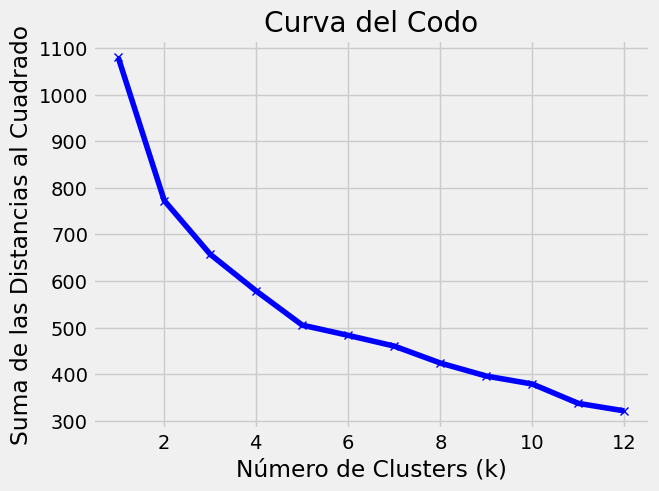

In [36]:
# Usar df_cluster
elbow_method(df_cluster)


c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

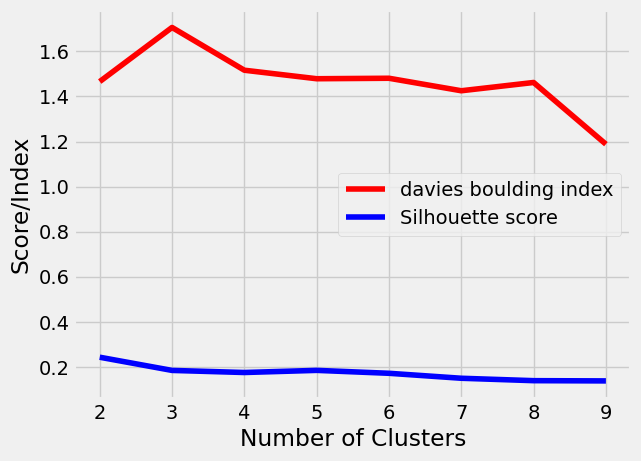

In [37]:
#script para representar coeficiente de silueta y de davies para ver numero de clusters
# Usar df_cluster
from sklearn.metrics import davies_bouldin_score, silhouette_score
 

silhouette_coefficients = []
davies_bouldin_scores = []
# Notice we start at 2 clusters for silhouette coefficient
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_cluster)
    sil_score = silhouette_score(df_cluster, kmeans.labels_)
    silhouette_coefficients.append(sil_score)
    db_score = davies_bouldin_score(df_cluster, kmeans.labels_)
    davies_bouldin_scores.append(db_score)
 

plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), davies_bouldin_scores, color='red', label = 'davies boulding index')
plt.plot(range(2, 10), silhouette_coefficients, color='blue', label = 'Silhouette score')
plt.xticks(range(2, 10))

plt.xlabel("Number of Clusters")
plt.ylabel("Score/Index")
plt.legend()
plt.show()

In [39]:
# Cluster Kmeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_cluster)
#df_t['Cluster_label']=kmeans.labels_
df_pca['Cluster_label']=kmeans.labels_


c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<Figure size 800x500 with 0 Axes>

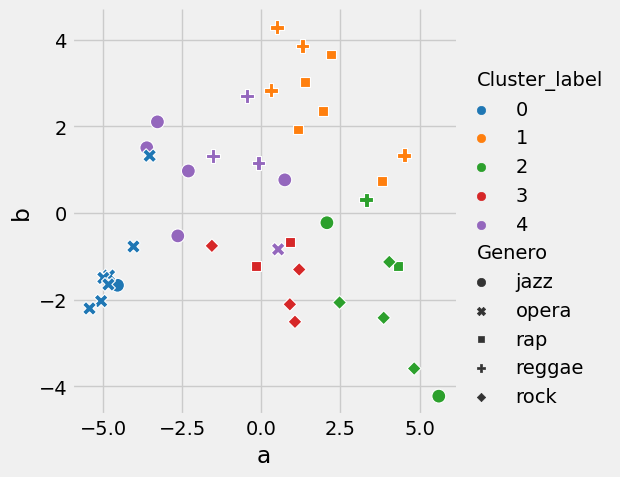

In [40]:
#representación perra clusters
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.relplot(data=df_pca, x='a', y='b', hue='Cluster_label', style='Genero', palette="tab10",s =100)


<BarContainer object of 27 artists>

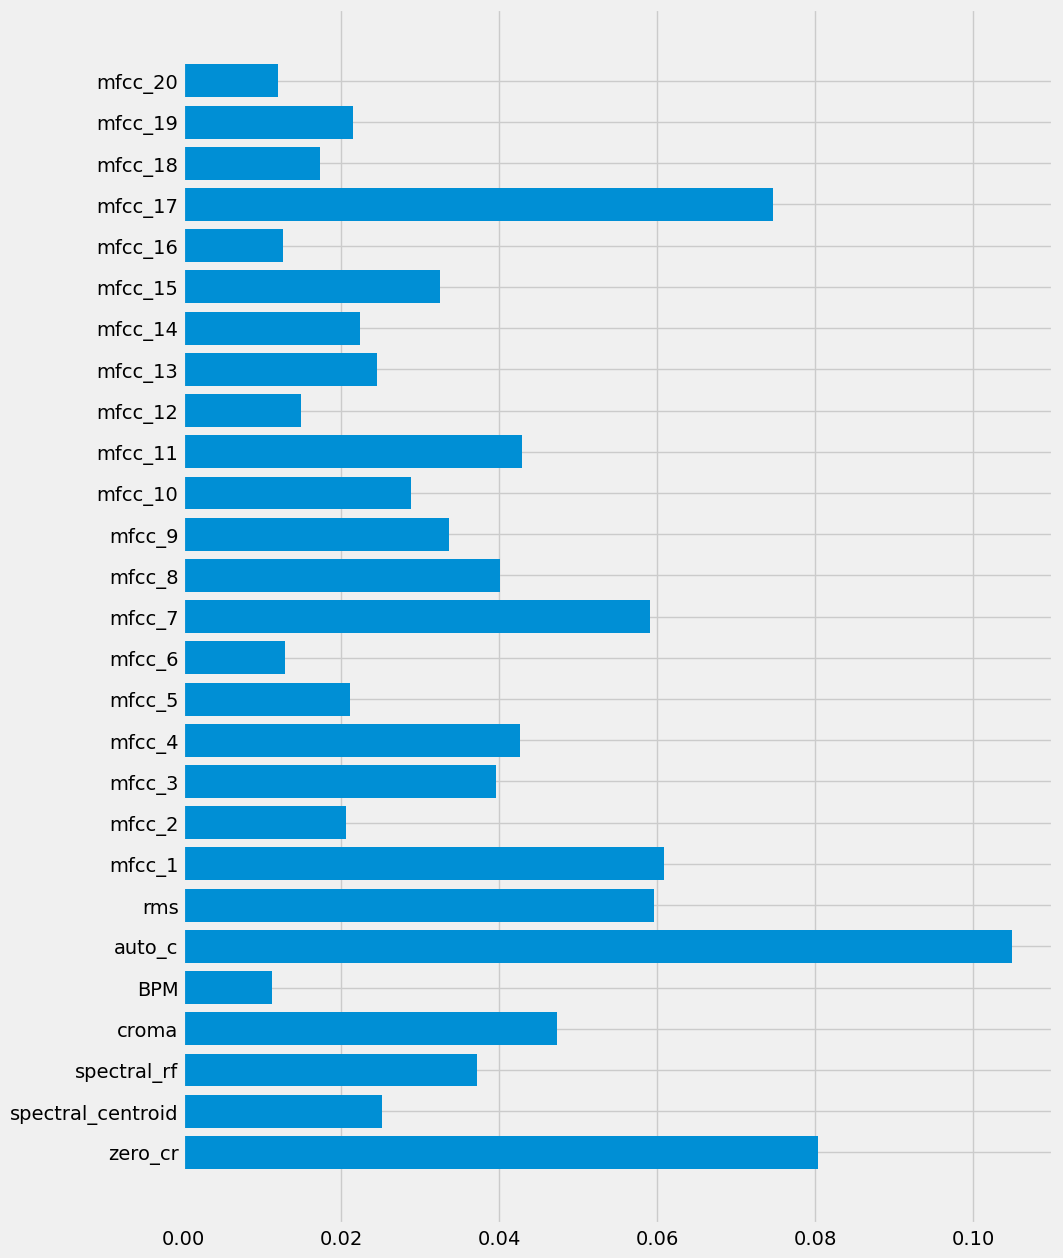

In [41]:
#Modelo Random Forest e importancia de las variables.
from sklearn.ensemble import RandomForestClassifier
reg=RandomForestClassifier()
reg.fit(X = X_train, y = y_train)
plt.figure(figsize = (10,15))
plt.barh(reg.feature_names_in_,reg.feature_importances_)

In [44]:
# Evaluacion conjunto de test modelo Random
pred=reg.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(pred,y_test)


array([[0.55, 0.27, 0.04, 0.07, 0.07],
       [0.05, 0.07, 0.29, 0.06, 0.53],
       [0.09, 0.06, 0.11, 0.7 , 0.04],
       [0.17, 0.51, 0.06, 0.26, 0.  ],
       [0.21, 0.29, 0.16, 0.13, 0.21],
       [0.56, 0.23, 0.05, 0.13, 0.03],
       [0.03, 0.08, 0.36, 0.47, 0.06],
       [0.14, 0.02, 0.26, 0.54, 0.04]])

In [49]:
reg.predict_proba(X_test)
pred,y_test

(array([4, 3, 4, 1, 0, 4, 2, 2]),
 3     0
 39    4
 25    3
 8     1
 32    4
 1     0
 19    2
 17    2
 Name: Genero_label, dtype: int64)

In [79]:
# Modelo Kmeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_train)
pred=kmeans.predict(X_test)



c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [69]:
#Cluster Jerarquico Aglomerativo

from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=0).fit(df_cluster)


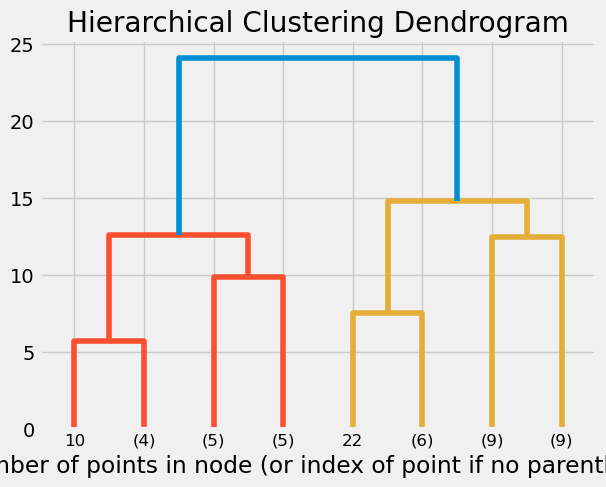

In [78]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()